# 1. CNN (Two dimensional)

## 1.1 Loading data

In [1]:
import csv
from math import sqrt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np

class UltrasonicData:
    """ A custom data type: the data member is 
    - the distances from the car to the surrounding wall at one or multiple sample time
    - and corresponding control commands for the angular velocity.
    """
    def __init__(self, distance, angular):
        self.distance = distance
        self.angular  = angular
        
        
def csv_read(csv_path, length):
    """ Reading raw ultrasonic data from csv file
    
    input: 
     - csv_path: the path of the csv file
     - length: the length of time sequence used in each training data
    output: 
     - Return the shuffled data which is represented in UltrasonicData type.
    """
    
    print("Starting reading data from csv file...")
    # save time-ordered data sequences
    D = []
    agl = []
    # save time-independent data by slicing D with the desired length 
    Data = []
    
    with open(csv_path, 'r') as f:
        f_reader = csv.reader(f)
        for line in f_reader:
            D.append([sqrt(float(line[i])**2 + float(line[i+16])**2) for i in range(16)])
            agl.append(float(line[33]))
    
    # now the data is sorted by time
    print("{} original data has been read in time order.".format(len(D)))
    
    for i in range(len(D)-length+1):
        distance = D[i:i+length]
        # use the value at the final time sequence as a label
        angular = agl[i+length-1] 
        
        Data.append(UltrasonicData(distance, angular))
    
    print("Now we have {} data after slicing with length {}".format(len(Data), length))
    
    return shuffle(Data)


def loading_data_set(csv_path, length, split=0.2):
    """ Loading and spliting dataset
    
    """
    Data = csv_read(csv_path, length)
    training_set, validation_set = train_test_split(Data, test_size=split)
    
    print("The training set size is {}".format(len(training_set)))
    print("The validation set size is {}".format(len(validation_set)))

    
    return training_set, validation_set


def data_generator(Data, batch_size):
    """ A data generator which generating a batch of data every time
    1. The data is reshaped to (batch_size, length*16)
    
    """
    while True:
        data_batch = np.random.choice(a=Data, size=batch_size)
        X = []
        Y = []
    
        for i in range(len(data_batch)):
            data = data_batch[i]
            # repeat coloums and rows 12 times
            array = np.array(data.distance)
            data_repeat = array.repeat(12, axis=0)
            data_repeat = data_repeat.repeat(12, axis=1)

            X.append(data_repeat)
            Y.append(data.angular)
            
        # batch_size, H, W = X.shape
        X = np.array(X)
        
        # add new axis for the gray scale image
        X = X[:, np.newaxis, :,:]
        Y = np.array(Y)
    
        yield shuffle(X,Y)

In [2]:
"""
TESTING DATA LOADING FUNCTION
"""

data_path  = "/media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I/"
filename = "2019-06-06.csv"
csv_path = data_path + filename
batch_size = 128
lengths = [16,32,48]

for length in lengths:
    training_set, validation_set = loading_data_set(csv_path, length, split=0.2)
    # load data through generator
    
    train_generator = data_generator(training_set, batch_size)
    valid_generator = data_generator(validation_set, batch_size)
    
    x1,y1 = next(train_generator)
    x2,y2 = next(valid_generator)
    print x1.shape, y1.shape
    print x2.shape, y2.shape
    print

Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6494 data after slicing with length 16
The training set size is 5195
The validation set size is 1299
(128, 1, 192, 192) (128,)
(128, 1, 192, 192) (128,)

Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6478 data after slicing with length 32
The training set size is 5182
The validation set size is 1296
(128, 1, 384, 192) (128,)
(128, 1, 384, 192) (128,)

Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6462 data after slicing with length 48
The training set size is 5169
The validation set size is 1293
(128, 1, 576, 192) (128,)
(128, 1, 576, 192) (128,)



## 1.2 Training


In [3]:
from math import ceil
from keras.models import Model
from keras.layers import Input, Activation, Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import add
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


data_path  = "/media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I/"
filename = "2019-06-06.csv"
csv_path = data_path + filename

batch_size = 128
epochs = 1000

lengths = [16, 32, 48]

historys = {}
errors = {}

model_path = "/home/ubuntu16/catkin_ws/src/sonar_navigation/h5/"


for length in lengths:
    # reading data from csv
    training_set, validation_set = loading_data_set(csv_path, length, split=0.2)
    # loading data through generator
    train_generator = data_generator(training_set, batch_size)
    valid_generator = data_generator(validation_set, batch_size)
    
    training_steps = ceil(len(training_set)/batch_size)
    validation_steps = ceil(len(validation_set)/batch_size)
    
    prefix = 'resnet8'+'-'+str(length)
    
    img_channel = 1
    img_height  = length*12
    img_width   = 16*12
    
    # Input
    img_input = Input(shape=(img_channel, img_height, img_width))

    x1 = Conv2D(32, (5, 5), strides=[2,2], padding='same', data_format='channels_first')(img_input)
    x1 = MaxPooling2D(pool_size=(3, 3), strides=[2,2], data_format='channels_first')(x1)

    # First residual block
    x2 = BatchNormalization(axis=1)(x1)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(32, (3, 3), strides=[2,2], padding='same',
                data_format='channels_first',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x2)

    x2 = BatchNormalization(axis=1)(x2)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(32, (3, 3), padding='same',
                data_format='channels_first',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x2)

    x1 = Conv2D(32, (1, 1), strides=[2,2], padding='same', data_format='channels_first')(x1)
    x3 = add([x1, x2])

    # Second residual block
    x4 = BatchNormalization(axis=1)(x3)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(64, (3, 3), strides=[2,2], padding='same',
                data_format='channels_first',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x4)

    x4 = BatchNormalization(axis=1)(x4)
    x4 = Activation('relu')(x4)
    x4 = Conv2D(64, (3, 3), padding='same',
                data_format='channels_first',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x4)

    x3 = Conv2D(64, (1, 1), strides=[2,2], padding='same', data_format='channels_first')(x3)
    x5 = add([x3, x4])

    # Third residual block
    x6 = BatchNormalization(axis=1)(x5)
    x6 = Activation('relu')(x6)
    x6 = Conv2D(128, (3, 3), strides=[2,2], padding='same',
                data_format='channels_first',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x6)

    x6 = BatchNormalization(axis=1)(x6)
    x6 = Activation('relu')(x6)
    x6 = Conv2D(128, (3, 3), padding='same',
                data_format='channels_first',
                kernel_initializer="he_normal",
                kernel_regularizer=regularizers.l2(1e-4))(x6)

    x5 = Conv2D(128, (1, 1), strides=[2,2], padding='same', data_format='channels_first')(x5)
    x7 = add([x5, x6])

    x = Flatten(data_format='channels_first')(x7)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    # Steering channel
    steer = Dense(1)(x)

    # Define steering model
    model = Model(inputs=[img_input], outputs=[steer])
    
    optimizer = optimizers.Adam(decay=1e-5)
    
    # compile        
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])
    model.summary()
    model_checkpoint = ModelCheckpoint(model_path+prefix+'-'+'best_model.h5', 
                                       monitor='val_mean_absolute_error',
                                       save_best_only=True)
    model_callbacks = [model_checkpoint]

    # fit model
    history = model.fit_generator(generator = train_generator,
                                  steps_per_epoch  = training_steps,
                                  validation_data  = valid_generator,
                                  validation_steps = validation_steps,
                                  epochs  = epochs,
                                  verbose = 1,
                                  callbacks = model_callbacks)
    # save training histroys
    hist_key = prefix + '-'+'mae'
            
    historys[hist_key] = history
        
    # load the saved model
    saved_model = load_model(model_path+prefix+'-'+'best_model.h5')
        
    # evalute model
    train_loss, train_mae = saved_model.evaluate_generator(train_generator, 
                                                               steps=training_steps,
                                                               verbose=0)
    val_loss, val_mae= saved_model.evaluate_generator(valid_generator, 
                                                          steps=validation_steps,
                                                          verbose=0)
    errors[prefix+'-'+'train'] = train_mae
    errors[prefix+'-'+'val'] = val_mae


    print('{}: Train: {}, validation: {}'.format(hist_key, train_mae, val_mae))
    print(" ")



Using TensorFlow backend.


Starting reading data from csv file...
6509 original data has been read in time order.
Now we have 6494 data after slicing with length 16
The training set size is 5195
The validation set size is 1299
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 192, 192)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 96, 96)   832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 47, 47)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_no

40/40 [==============================] - 3s 67ms/step - loss: 0.0674 - mean_absolute_error: 0.0276 - val_loss: 0.0635 - val_mean_absolute_error: 0.0241
Epoch 56/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0669 - mean_absolute_error: 0.0277 - val_loss: 0.0671 - val_mean_absolute_error: 0.0283
Epoch 57/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0663 - mean_absolute_error: 0.0278 - val_loss: 0.0663 - val_mean_absolute_error: 0.0281
Epoch 58/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0650 - mean_absolute_error: 0.0271 - val_loss: 0.0602 - val_mean_absolute_error: 0.0226
Epoch 59/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0655 - mean_absolute_error: 0.0282 - val_loss: 0.0594 - val_mean_absolute_error: 0.0225
Epoch 60/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0653 - mean_absolute_error: 0.0286 - val_loss: 0.0657 - val_mean_absolute_error: 0.0294
Epoch 61/1000
40/4

40/40 [==============================] - 3s 68ms/step - loss: 0.0274 - mean_absolute_error: 0.0211 - val_loss: 0.0296 - val_mean_absolute_error: 0.0234
Epoch 154/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0277 - mean_absolute_error: 0.0215 - val_loss: 0.0313 - val_mean_absolute_error: 0.0251
Epoch 155/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0282 - mean_absolute_error: 0.0221 - val_loss: 0.0263 - val_mean_absolute_error: 0.0202
Epoch 156/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0274 - mean_absolute_error: 0.0214 - val_loss: 0.0283 - val_mean_absolute_error: 0.0224
Epoch 157/1000
40/40 [==============================] - 3s 64ms/step - loss: 0.0273 - mean_absolute_error: 0.0213 - val_loss: 0.0304 - val_mean_absolute_error: 0.0245
Epoch 158/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0263 - mean_absolute_error: 0.0205 - val_loss: 0.0302 - val_mean_absolute_error: 0.0244
Epoch 159/100

40/40 [==============================] - 3s 68ms/step - loss: 0.0207 - mean_absolute_error: 0.0169 - val_loss: 0.0260 - val_mean_absolute_error: 0.0223
Epoch 252/1000
40/40 [==============================] - 3s 70ms/step - loss: 0.0226 - mean_absolute_error: 0.0190 - val_loss: 0.0221 - val_mean_absolute_error: 0.0185
Epoch 253/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0240 - mean_absolute_error: 0.0205 - val_loss: 0.0312 - val_mean_absolute_error: 0.0276
Epoch 254/1000
40/40 [==============================] - 3s 64ms/step - loss: 0.0224 - mean_absolute_error: 0.0188 - val_loss: 0.0414 - val_mean_absolute_error: 0.0378
Epoch 255/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0232 - mean_absolute_error: 0.0196 - val_loss: 0.0228 - val_mean_absolute_error: 0.0193
Epoch 256/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0205 - mean_absolute_error: 0.0170 - val_loss: 0.0384 - val_mean_absolute_error: 0.0350
Epoch 257/100

40/40 [==============================] - 3s 64ms/step - loss: 0.0177 - mean_absolute_error: 0.0151 - val_loss: 0.0280 - val_mean_absolute_error: 0.0255
Epoch 350/1000
40/40 [==============================] - 3s 63ms/step - loss: 0.0196 - mean_absolute_error: 0.0170 - val_loss: 0.0315 - val_mean_absolute_error: 0.0289
Epoch 351/1000
40/40 [==============================] - 3s 64ms/step - loss: 0.0202 - mean_absolute_error: 0.0177 - val_loss: 0.0210 - val_mean_absolute_error: 0.0184
Epoch 352/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0200 - mean_absolute_error: 0.0175 - val_loss: 0.0281 - val_mean_absolute_error: 0.0255
Epoch 353/1000
40/40 [==============================] - 3s 64ms/step - loss: 0.0214 - mean_absolute_error: 0.0187 - val_loss: 0.0281 - val_mean_absolute_error: 0.0253
Epoch 354/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0201 - mean_absolute_error: 0.0174 - val_loss: 0.0395 - val_mean_absolute_error: 0.0369
Epoch 355/100

40/40 [==============================] - 3s 64ms/step - loss: 0.0173 - mean_absolute_error: 0.0151 - val_loss: 0.0197 - val_mean_absolute_error: 0.0176
Epoch 448/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0190 - mean_absolute_error: 0.0168 - val_loss: 0.0296 - val_mean_absolute_error: 0.0275
Epoch 449/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0186 - mean_absolute_error: 0.0165 - val_loss: 0.0292 - val_mean_absolute_error: 0.0271
Epoch 450/1000
40/40 [==============================] - 3s 64ms/step - loss: 0.0190 - mean_absolute_error: 0.0169 - val_loss: 0.0254 - val_mean_absolute_error: 0.0233
Epoch 451/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0177 - mean_absolute_error: 0.0156 - val_loss: 0.0190 - val_mean_absolute_error: 0.0169
Epoch 452/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0189 - mean_absolute_error: 0.0169 - val_loss: 0.0281 - val_mean_absolute_error: 0.0261
Epoch 453/100

40/40 [==============================] - 3s 66ms/step - loss: 0.0177 - mean_absolute_error: 0.0158 - val_loss: 0.0197 - val_mean_absolute_error: 0.0178
Epoch 546/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0172 - mean_absolute_error: 0.0153 - val_loss: 0.0198 - val_mean_absolute_error: 0.0179
Epoch 547/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0168 - mean_absolute_error: 0.0150 - val_loss: 0.0320 - val_mean_absolute_error: 0.0302
Epoch 548/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0172 - mean_absolute_error: 0.0153 - val_loss: 0.0233 - val_mean_absolute_error: 0.0214
Epoch 549/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0199 - mean_absolute_error: 0.0180 - val_loss: 0.0469 - val_mean_absolute_error: 0.0450
Epoch 550/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0171 - mean_absolute_error: 0.0152 - val_loss: 0.0333 - val_mean_absolute_error: 0.0314
Epoch 551/100

40/40 [==============================] - 3s 65ms/step - loss: 0.0168 - mean_absolute_error: 0.0151 - val_loss: 0.0197 - val_mean_absolute_error: 0.0180
Epoch 644/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0166 - mean_absolute_error: 0.0150 - val_loss: 0.0206 - val_mean_absolute_error: 0.0189
Epoch 645/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0164 - mean_absolute_error: 0.0147 - val_loss: 0.0304 - val_mean_absolute_error: 0.0287
Epoch 646/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0178 - mean_absolute_error: 0.0161 - val_loss: 0.0198 - val_mean_absolute_error: 0.0181
Epoch 647/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0174 - mean_absolute_error: 0.0157 - val_loss: 0.0285 - val_mean_absolute_error: 0.0268
Epoch 648/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0167 - mean_absolute_error: 0.0150 - val_loss: 0.0175 - val_mean_absolute_error: 0.0159
Epoch 649/100

Epoch 692/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0164 - mean_absolute_error: 0.0148 - val_loss: 0.0210 - val_mean_absolute_error: 0.0194
Epoch 693/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0167 - mean_absolute_error: 0.0152 - val_loss: 0.0220 - val_mean_absolute_error: 0.0204
Epoch 694/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0161 - mean_absolute_error: 0.0145 - val_loss: 0.0277 - val_mean_absolute_error: 0.0262
Epoch 695/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0166 - mean_absolute_error: 0.0150 - val_loss: 0.0250 - val_mean_absolute_error: 0.0234
Epoch 696/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0171 - mean_absolute_error: 0.0155 - val_loss: 0.0247 - val_mean_absolute_error: 0.0231
Epoch 697/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0163 - mean_absolute_error: 0.0147 - val_loss: 0.0223 - val_mean_absolute_error: 0.020

40/40 [==============================] - 3s 68ms/step - loss: 0.0163 - mean_absolute_error: 0.0147 - val_loss: 0.0205 - val_mean_absolute_error: 0.0190
Epoch 742/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0157 - mean_absolute_error: 0.0141 - val_loss: 0.0203 - val_mean_absolute_error: 0.0187
Epoch 743/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0153 - mean_absolute_error: 0.0137 - val_loss: 0.0221 - val_mean_absolute_error: 0.0206
Epoch 744/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0165 - mean_absolute_error: 0.0149 - val_loss: 0.0209 - val_mean_absolute_error: 0.0194
Epoch 745/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0163 - mean_absolute_error: 0.0147 - val_loss: 0.0190 - val_mean_absolute_error: 0.0174
Epoch 746/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0151 - mean_absolute_error: 0.0135 - val_loss: 0.0236 - val_mean_absolute_error: 0.0221
Epoch 747/100

40/40 [==============================] - 3s 65ms/step - loss: 0.0152 - mean_absolute_error: 0.0136 - val_loss: 0.0212 - val_mean_absolute_error: 0.0196
Epoch 840/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0159 - mean_absolute_error: 0.0143 - val_loss: 0.0238 - val_mean_absolute_error: 0.0222
Epoch 841/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0152 - mean_absolute_error: 0.0137 - val_loss: 0.0354 - val_mean_absolute_error: 0.0338
Epoch 842/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0153 - mean_absolute_error: 0.0138 - val_loss: 0.0210 - val_mean_absolute_error: 0.0195
Epoch 843/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0146 - mean_absolute_error: 0.0130 - val_loss: 0.0213 - val_mean_absolute_error: 0.0197
Epoch 844/1000
40/40 [==============================] - 3s 64ms/step - loss: 0.0160 - mean_absolute_error: 0.0145 - val_loss: 0.0301 - val_mean_absolute_error: 0.0285
Epoch 845/100

40/40 [==============================] - 3s 64ms/step - loss: 0.0159 - mean_absolute_error: 0.0144 - val_loss: 0.0315 - val_mean_absolute_error: 0.0301
Epoch 938/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0152 - mean_absolute_error: 0.0137 - val_loss: 0.0290 - val_mean_absolute_error: 0.0276
Epoch 939/1000
40/40 [==============================] - 3s 69ms/step - loss: 0.0149 - mean_absolute_error: 0.0134 - val_loss: 0.0232 - val_mean_absolute_error: 0.0218
Epoch 940/1000
40/40 [==============================] - 3s 67ms/step - loss: 0.0162 - mean_absolute_error: 0.0148 - val_loss: 0.0245 - val_mean_absolute_error: 0.0231
Epoch 941/1000
40/40 [==============================] - 3s 70ms/step - loss: 0.0152 - mean_absolute_error: 0.0137 - val_loss: 0.0190 - val_mean_absolute_error: 0.0175
Epoch 942/1000
40/40 [==============================] - 3s 68ms/step - loss: 0.0153 - mean_absolute_error: 0.0138 - val_loss: 0.0187 - val_mean_absolute_error: 0.0173
Epoch 943/100

Epoch 1/1000
40/40 [==============================] - 8s 193ms/step - loss: 0.8076 - mean_absolute_error: 0.7378 - val_loss: 0.1234 - val_mean_absolute_error: 0.0533
Epoch 2/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.1152 - mean_absolute_error: 0.0451 - val_loss: 0.1045 - val_mean_absolute_error: 0.0345
Epoch 3/1000
40/40 [==============================] - 6s 150ms/step - loss: 0.1071 - mean_absolute_error: 0.0372 - val_loss: 0.0995 - val_mean_absolute_error: 0.0297
Epoch 4/1000
40/40 [==============================] - 6s 155ms/step - loss: 0.1076 - mean_absolute_error: 0.0379 - val_loss: 0.0994 - val_mean_absolute_error: 0.0299
Epoch 5/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.1068 - mean_absolute_error: 0.0374 - val_loss: 0.0942 - val_mean_absolute_error: 0.0250
Epoch 6/1000
40/40 [==============================] - 6s 152ms/step - loss: 0.1041 - mean_absolute_error: 0.0351 - val_loss: 0.0966 - val_mean_absolute_error: 0.0277
Epoc

40/40 [==============================] - 6s 147ms/step - loss: 0.0413 - mean_absolute_error: 0.0251 - val_loss: 0.0408 - val_mean_absolute_error: 0.0247
Epoch 100/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0413 - mean_absolute_error: 0.0254 - val_loss: 0.0387 - val_mean_absolute_error: 0.0230
Epoch 101/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0392 - mean_absolute_error: 0.0237 - val_loss: 0.0395 - val_mean_absolute_error: 0.0242
Epoch 102/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0402 - mean_absolute_error: 0.0251 - val_loss: 0.0360 - val_mean_absolute_error: 0.0210
Epoch 103/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0406 - mean_absolute_error: 0.0258 - val_loss: 0.0368 - val_mean_absolute_error: 0.0221
Epoch 104/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0400 - mean_absolute_error: 0.0254 - val_loss: 0.0360 - val_mean_absolute_error: 0.0216
Epoch 1

Epoch 148/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0311 - mean_absolute_error: 0.0244 - val_loss: 0.0309 - val_mean_absolute_error: 0.0243
Epoch 149/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0296 - mean_absolute_error: 0.0230 - val_loss: 0.0325 - val_mean_absolute_error: 0.0260
Epoch 150/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0290 - mean_absolute_error: 0.0225 - val_loss: 0.0347 - val_mean_absolute_error: 0.0283
Epoch 151/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0291 - mean_absolute_error: 0.0228 - val_loss: 0.0285 - val_mean_absolute_error: 0.0223
Epoch 152/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0279 - mean_absolute_error: 0.0217 - val_loss: 0.0432 - val_mean_absolute_error: 0.0371
Epoch 153/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0282 - mean_absolute_error: 0.0222 - val_loss: 0.0291 - val_mean_absolute_error:

Epoch 197/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0246 - mean_absolute_error: 0.0209 - val_loss: 0.0406 - val_mean_absolute_error: 0.0369
Epoch 198/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0259 - mean_absolute_error: 0.0222 - val_loss: 0.0307 - val_mean_absolute_error: 0.0270
Epoch 199/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0240 - mean_absolute_error: 0.0202 - val_loss: 0.0577 - val_mean_absolute_error: 0.0538
Epoch 200/1000
40/40 [==============================] - 6s 151ms/step - loss: 0.0257 - mean_absolute_error: 0.0218 - val_loss: 0.0283 - val_mean_absolute_error: 0.0244
Epoch 201/1000
40/40 [==============================] - 6s 151ms/step - loss: 0.0243 - mean_absolute_error: 0.0203 - val_loss: 0.0726 - val_mean_absolute_error: 0.0683
Epoch 202/1000
40/40 [==============================] - 6s 152ms/step - loss: 0.0250 - mean_absolute_error: 0.0206 - val_loss: 0.0262 - val_mean_absolute_error:

Epoch 246/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0232 - mean_absolute_error: 0.0198 - val_loss: 0.0443 - val_mean_absolute_error: 0.0409
Epoch 247/1000
40/40 [==============================] - 6s 151ms/step - loss: 0.0232 - mean_absolute_error: 0.0198 - val_loss: 0.0371 - val_mean_absolute_error: 0.0337
Epoch 248/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0218 - mean_absolute_error: 0.0184 - val_loss: 0.0319 - val_mean_absolute_error: 0.0285
Epoch 249/1000
40/40 [==============================] - 6s 150ms/step - loss: 0.0226 - mean_absolute_error: 0.0192 - val_loss: 0.0196 - val_mean_absolute_error: 0.0162
Epoch 250/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0216 - mean_absolute_error: 0.0183 - val_loss: 0.0520 - val_mean_absolute_error: 0.0487
Epoch 251/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0215 - mean_absolute_error: 0.0182 - val_loss: 0.0264 - val_mean_absolute_error:

Epoch 295/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0209 - mean_absolute_error: 0.0180 - val_loss: 0.0295 - val_mean_absolute_error: 0.0265
Epoch 296/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0211 - mean_absolute_error: 0.0182 - val_loss: 0.0352 - val_mean_absolute_error: 0.0323
Epoch 297/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0195 - mean_absolute_error: 0.0166 - val_loss: 0.0229 - val_mean_absolute_error: 0.0200
Epoch 298/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0196 - mean_absolute_error: 0.0166 - val_loss: 0.0312 - val_mean_absolute_error: 0.0282
Epoch 299/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0204 - mean_absolute_error: 0.0173 - val_loss: 0.0312 - val_mean_absolute_error: 0.0282
Epoch 300/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0210 - mean_absolute_error: 0.0180 - val_loss: 0.0417 - val_mean_absolute_error:

Epoch 344/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0212 - mean_absolute_error: 0.0188 - val_loss: 0.0233 - val_mean_absolute_error: 0.0208
Epoch 345/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0200 - mean_absolute_error: 0.0174 - val_loss: 0.0288 - val_mean_absolute_error: 0.0261
Epoch 346/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0196 - mean_absolute_error: 0.0170 - val_loss: 0.0351 - val_mean_absolute_error: 0.0325
Epoch 347/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0200 - mean_absolute_error: 0.0175 - val_loss: 0.0533 - val_mean_absolute_error: 0.0508
Epoch 348/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0191 - mean_absolute_error: 0.0166 - val_loss: 0.0322 - val_mean_absolute_error: 0.0298
Epoch 349/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0194 - mean_absolute_error: 0.0170 - val_loss: 0.0220 - val_mean_absolute_error:

Epoch 393/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0207 - mean_absolute_error: 0.0183 - val_loss: 0.0285 - val_mean_absolute_error: 0.0261
Epoch 394/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0197 - mean_absolute_error: 0.0173 - val_loss: 0.0215 - val_mean_absolute_error: 0.0192
Epoch 395/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0200 - mean_absolute_error: 0.0176 - val_loss: 0.0195 - val_mean_absolute_error: 0.0172
Epoch 396/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0195 - mean_absolute_error: 0.0172 - val_loss: 0.0237 - val_mean_absolute_error: 0.0214
Epoch 397/1000
40/40 [==============================] - 6s 152ms/step - loss: 0.0186 - mean_absolute_error: 0.0163 - val_loss: 0.0191 - val_mean_absolute_error: 0.0167
Epoch 398/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0196 - mean_absolute_error: 0.0171 - val_loss: 0.0258 - val_mean_absolute_error:

Epoch 442/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0188 - mean_absolute_error: 0.0167 - val_loss: 0.0251 - val_mean_absolute_error: 0.0229
Epoch 443/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0183 - mean_absolute_error: 0.0161 - val_loss: 0.0205 - val_mean_absolute_error: 0.0183
Epoch 444/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0171 - mean_absolute_error: 0.0149 - val_loss: 0.0199 - val_mean_absolute_error: 0.0177
Epoch 445/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0190 - mean_absolute_error: 0.0169 - val_loss: 0.0213 - val_mean_absolute_error: 0.0192
Epoch 446/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0178 - mean_absolute_error: 0.0157 - val_loss: 0.0216 - val_mean_absolute_error: 0.0195
Epoch 447/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0184 - mean_absolute_error: 0.0163 - val_loss: 0.0230 - val_mean_absolute_error:

Epoch 491/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0176 - mean_absolute_error: 0.0157 - val_loss: 0.0221 - val_mean_absolute_error: 0.0202
Epoch 492/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0193 - mean_absolute_error: 0.0173 - val_loss: 0.0225 - val_mean_absolute_error: 0.0205
Epoch 493/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0185 - mean_absolute_error: 0.0166 - val_loss: 0.0312 - val_mean_absolute_error: 0.0292
Epoch 494/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0184 - mean_absolute_error: 0.0164 - val_loss: 0.0235 - val_mean_absolute_error: 0.0215
Epoch 495/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0180 - mean_absolute_error: 0.0160 - val_loss: 0.0270 - val_mean_absolute_error: 0.0250
Epoch 496/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0183 - mean_absolute_error: 0.0164 - val_loss: 0.0244 - val_mean_absolute_error:

Epoch 540/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0170 - mean_absolute_error: 0.0152 - val_loss: 0.0207 - val_mean_absolute_error: 0.0189
Epoch 541/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0179 - mean_absolute_error: 0.0161 - val_loss: 0.0374 - val_mean_absolute_error: 0.0356
Epoch 542/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0167 - mean_absolute_error: 0.0149 - val_loss: 0.0236 - val_mean_absolute_error: 0.0218
Epoch 543/1000
40/40 [==============================] - 6s 150ms/step - loss: 0.0170 - mean_absolute_error: 0.0152 - val_loss: 0.0301 - val_mean_absolute_error: 0.0284
Epoch 544/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0179 - mean_absolute_error: 0.0162 - val_loss: 0.0220 - val_mean_absolute_error: 0.0202
Epoch 545/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0172 - mean_absolute_error: 0.0154 - val_loss: 0.0300 - val_mean_absolute_error:

Epoch 589/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0170 - mean_absolute_error: 0.0153 - val_loss: 0.0261 - val_mean_absolute_error: 0.0244
Epoch 590/1000
40/40 [==============================] - 6s 152ms/step - loss: 0.0157 - mean_absolute_error: 0.0140 - val_loss: 0.0229 - val_mean_absolute_error: 0.0212
Epoch 591/1000
40/40 [==============================] - 6s 150ms/step - loss: 0.0169 - mean_absolute_error: 0.0152 - val_loss: 0.0272 - val_mean_absolute_error: 0.0255
Epoch 592/1000
40/40 [==============================] - 6s 153ms/step - loss: 0.0161 - mean_absolute_error: 0.0144 - val_loss: 0.0317 - val_mean_absolute_error: 0.0300
Epoch 593/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0175 - mean_absolute_error: 0.0158 - val_loss: 0.0265 - val_mean_absolute_error: 0.0248
Epoch 594/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0157 - mean_absolute_error: 0.0140 - val_loss: 0.0199 - val_mean_absolute_error:

Epoch 638/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0158 - mean_absolute_error: 0.0142 - val_loss: 0.0185 - val_mean_absolute_error: 0.0169
Epoch 639/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0165 - mean_absolute_error: 0.0149 - val_loss: 0.0345 - val_mean_absolute_error: 0.0329
Epoch 640/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0174 - mean_absolute_error: 0.0158 - val_loss: 0.0221 - val_mean_absolute_error: 0.0205
Epoch 641/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0154 - mean_absolute_error: 0.0138 - val_loss: 0.0196 - val_mean_absolute_error: 0.0180
Epoch 642/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0164 - mean_absolute_error: 0.0148 - val_loss: 0.0177 - val_mean_absolute_error: 0.0161
Epoch 643/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0157 - mean_absolute_error: 0.0141 - val_loss: 0.0199 - val_mean_absolute_error:

Epoch 687/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0156 - mean_absolute_error: 0.0141 - val_loss: 0.0241 - val_mean_absolute_error: 0.0225
Epoch 688/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0159 - mean_absolute_error: 0.0144 - val_loss: 0.0241 - val_mean_absolute_error: 0.0225
Epoch 689/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0163 - mean_absolute_error: 0.0147 - val_loss: 0.0239 - val_mean_absolute_error: 0.0223
Epoch 690/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0152 - mean_absolute_error: 0.0136 - val_loss: 0.0218 - val_mean_absolute_error: 0.0202
Epoch 691/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0162 - mean_absolute_error: 0.0146 - val_loss: 0.0216 - val_mean_absolute_error: 0.0200
Epoch 692/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0153 - mean_absolute_error: 0.0138 - val_loss: 0.0266 - val_mean_absolute_error:

Epoch 736/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0160 - mean_absolute_error: 0.0144 - val_loss: 0.0351 - val_mean_absolute_error: 0.0336
Epoch 737/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0153 - mean_absolute_error: 0.0137 - val_loss: 0.0335 - val_mean_absolute_error: 0.0320
Epoch 738/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0158 - mean_absolute_error: 0.0143 - val_loss: 0.0252 - val_mean_absolute_error: 0.0237
Epoch 739/1000
40/40 [==============================] - 6s 149ms/step - loss: 0.0159 - mean_absolute_error: 0.0144 - val_loss: 0.0214 - val_mean_absolute_error: 0.0198
Epoch 740/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0171 - mean_absolute_error: 0.0156 - val_loss: 0.0218 - val_mean_absolute_error: 0.0202
Epoch 741/1000
40/40 [==============================] - 6s 152ms/step - loss: 0.0158 - mean_absolute_error: 0.0142 - val_loss: 0.0203 - val_mean_absolute_error:

Epoch 785/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0151 - mean_absolute_error: 0.0136 - val_loss: 0.0177 - val_mean_absolute_error: 0.0162
Epoch 786/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0161 - mean_absolute_error: 0.0145 - val_loss: 0.0270 - val_mean_absolute_error: 0.0254
Epoch 787/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0144 - mean_absolute_error: 0.0128 - val_loss: 0.0306 - val_mean_absolute_error: 0.0291
Epoch 788/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0163 - mean_absolute_error: 0.0147 - val_loss: 0.0180 - val_mean_absolute_error: 0.0164
Epoch 789/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0155 - mean_absolute_error: 0.0139 - val_loss: 0.0199 - val_mean_absolute_error: 0.0184
Epoch 790/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0156 - mean_absolute_error: 0.0140 - val_loss: 0.0192 - val_mean_absolute_error:

Epoch 834/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0147 - mean_absolute_error: 0.0131 - val_loss: 0.0258 - val_mean_absolute_error: 0.0242
Epoch 835/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0150 - mean_absolute_error: 0.0134 - val_loss: 0.0263 - val_mean_absolute_error: 0.0247
Epoch 836/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0152 - mean_absolute_error: 0.0137 - val_loss: 0.0236 - val_mean_absolute_error: 0.0220
Epoch 837/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0155 - mean_absolute_error: 0.0139 - val_loss: 0.0233 - val_mean_absolute_error: 0.0218
Epoch 838/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0157 - mean_absolute_error: 0.0141 - val_loss: 0.0240 - val_mean_absolute_error: 0.0224
Epoch 839/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0164 - mean_absolute_error: 0.0149 - val_loss: 0.0316 - val_mean_absolute_error:

Epoch 883/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0150 - mean_absolute_error: 0.0135 - val_loss: 0.0160 - val_mean_absolute_error: 0.0144
Epoch 884/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0152 - mean_absolute_error: 0.0136 - val_loss: 0.0209 - val_mean_absolute_error: 0.0193
Epoch 885/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0146 - mean_absolute_error: 0.0130 - val_loss: 0.0175 - val_mean_absolute_error: 0.0159
Epoch 886/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0147 - mean_absolute_error: 0.0131 - val_loss: 0.0252 - val_mean_absolute_error: 0.0236
Epoch 887/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0151 - mean_absolute_error: 0.0135 - val_loss: 0.0190 - val_mean_absolute_error: 0.0174
Epoch 888/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0151 - mean_absolute_error: 0.0135 - val_loss: 0.0330 - val_mean_absolute_error:

Epoch 932/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0144 - mean_absolute_error: 0.0128 - val_loss: 0.0215 - val_mean_absolute_error: 0.0199
Epoch 933/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0150 - mean_absolute_error: 0.0134 - val_loss: 0.0284 - val_mean_absolute_error: 0.0268
Epoch 934/1000
40/40 [==============================] - 6s 148ms/step - loss: 0.0145 - mean_absolute_error: 0.0129 - val_loss: 0.0334 - val_mean_absolute_error: 0.0318
Epoch 935/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0146 - mean_absolute_error: 0.0130 - val_loss: 0.0176 - val_mean_absolute_error: 0.0160
Epoch 936/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0138 - mean_absolute_error: 0.0121 - val_loss: 0.0228 - val_mean_absolute_error: 0.0212
Epoch 937/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0147 - mean_absolute_error: 0.0131 - val_loss: 0.0197 - val_mean_absolute_error:

Epoch 981/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0145 - mean_absolute_error: 0.0129 - val_loss: 0.0184 - val_mean_absolute_error: 0.0167
Epoch 982/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0147 - mean_absolute_error: 0.0130 - val_loss: 0.0191 - val_mean_absolute_error: 0.0175
Epoch 983/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0146 - mean_absolute_error: 0.0129 - val_loss: 0.0203 - val_mean_absolute_error: 0.0186
Epoch 984/1000
40/40 [==============================] - 6s 146ms/step - loss: 0.0132 - mean_absolute_error: 0.0115 - val_loss: 0.0178 - val_mean_absolute_error: 0.0162
Epoch 985/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0140 - mean_absolute_error: 0.0123 - val_loss: 0.0180 - val_mean_absolute_error: 0.0164
Epoch 986/1000
40/40 [==============================] - 6s 147ms/step - loss: 0.0136 - mean_absolute_error: 0.0120 - val_loss: 0.0197 - val_mean_absolute_error:

Epoch 1/1000
40/40 [==============================] - 11s 284ms/step - loss: 0.7223 - mean_absolute_error: 0.6523 - val_loss: 0.1215 - val_mean_absolute_error: 0.0511
Epoch 2/1000
40/40 [==============================] - 9s 224ms/step - loss: 0.1129 - mean_absolute_error: 0.0426 - val_loss: 0.1045 - val_mean_absolute_error: 0.0343
Epoch 3/1000
40/40 [==============================] - 9s 223ms/step - loss: 0.1109 - mean_absolute_error: 0.0408 - val_loss: 0.1000 - val_mean_absolute_error: 0.0301
Epoch 4/1000
40/40 [==============================] - 9s 230ms/step - loss: 0.1068 - mean_absolute_error: 0.0370 - val_loss: 0.1049 - val_mean_absolute_error: 0.0353
Epoch 5/1000
40/40 [==============================] - 9s 224ms/step - loss: 0.1061 - mean_absolute_error: 0.0366 - val_loss: 0.0961 - val_mean_absolute_error: 0.0268
Epoch 6/1000
40/40 [==============================] - 9s 224ms/step - loss: 0.1017 - mean_absolute_error: 0.0327 - val_loss: 0.0971 - val_mean_absolute_error: 0.0283
Epo

40/40 [==============================] - 9s 224ms/step - loss: 0.0416 - mean_absolute_error: 0.0267 - val_loss: 0.0461 - val_mean_absolute_error: 0.0313
Epoch 100/1000
40/40 [==============================] - 9s 224ms/step - loss: 0.0388 - mean_absolute_error: 0.0241 - val_loss: 0.0365 - val_mean_absolute_error: 0.0219
Epoch 101/1000
40/40 [==============================] - 9s 228ms/step - loss: 0.0383 - mean_absolute_error: 0.0239 - val_loss: 0.0364 - val_mean_absolute_error: 0.0222
Epoch 102/1000
40/40 [==============================] - 9s 225ms/step - loss: 0.0389 - mean_absolute_error: 0.0248 - val_loss: 0.0448 - val_mean_absolute_error: 0.0309
Epoch 103/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0367 - mean_absolute_error: 0.0229 - val_loss: 0.0416 - val_mean_absolute_error: 0.0279
Epoch 104/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0378 - mean_absolute_error: 0.0243 - val_loss: 0.0442 - val_mean_absolute_error: 0.0309
Epoch 1

Epoch 148/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0270 - mean_absolute_error: 0.0212 - val_loss: 0.0303 - val_mean_absolute_error: 0.0246
Epoch 149/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0253 - mean_absolute_error: 0.0196 - val_loss: 0.0244 - val_mean_absolute_error: 0.0188
Epoch 150/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0256 - mean_absolute_error: 0.0200 - val_loss: 0.0289 - val_mean_absolute_error: 0.0234
Epoch 151/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0272 - mean_absolute_error: 0.0216 - val_loss: 0.0317 - val_mean_absolute_error: 0.0260
Epoch 152/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0257 - mean_absolute_error: 0.0201 - val_loss: 0.0398 - val_mean_absolute_error: 0.0343
Epoch 153/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0265 - mean_absolute_error: 0.0211 - val_loss: 0.0380 - val_mean_absolute_error:

Epoch 197/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0226 - mean_absolute_error: 0.0186 - val_loss: 0.0279 - val_mean_absolute_error: 0.0238
Epoch 198/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0225 - mean_absolute_error: 0.0185 - val_loss: 0.0256 - val_mean_absolute_error: 0.0217
Epoch 199/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0230 - mean_absolute_error: 0.0190 - val_loss: 0.0325 - val_mean_absolute_error: 0.0286
Epoch 200/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0229 - mean_absolute_error: 0.0191 - val_loss: 0.0250 - val_mean_absolute_error: 0.0212
Epoch 201/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0230 - mean_absolute_error: 0.0192 - val_loss: 0.0354 - val_mean_absolute_error: 0.0317
Epoch 202/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0231 - mean_absolute_error: 0.0193 - val_loss: 0.0394 - val_mean_absolute_error:

Epoch 246/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0224 - mean_absolute_error: 0.0192 - val_loss: 0.0228 - val_mean_absolute_error: 0.0195
Epoch 247/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0219 - mean_absolute_error: 0.0186 - val_loss: 0.0367 - val_mean_absolute_error: 0.0335
Epoch 248/1000
40/40 [==============================] - 9s 228ms/step - loss: 0.0228 - mean_absolute_error: 0.0195 - val_loss: 0.0378 - val_mean_absolute_error: 0.0345
Epoch 249/1000
40/40 [==============================] - 10s 245ms/step - loss: 0.0218 - mean_absolute_error: 0.0186 - val_loss: 0.0247 - val_mean_absolute_error: 0.0216
Epoch 250/1000
40/40 [==============================] - 9s 231ms/step - loss: 0.0206 - mean_absolute_error: 0.0175 - val_loss: 0.0199 - val_mean_absolute_error: 0.0169
Epoch 251/1000
40/40 [==============================] - 9s 223ms/step - loss: 0.0227 - mean_absolute_error: 0.0197 - val_loss: 0.0520 - val_mean_absolute_error

Epoch 295/1000
40/40 [==============================] - 9s 223ms/step - loss: 0.0210 - mean_absolute_error: 0.0178 - val_loss: 0.0346 - val_mean_absolute_error: 0.0314
Epoch 296/1000
40/40 [==============================] - 9s 224ms/step - loss: 0.0207 - mean_absolute_error: 0.0175 - val_loss: 0.0456 - val_mean_absolute_error: 0.0425
Epoch 297/1000
40/40 [==============================] - 9s 224ms/step - loss: 0.0201 - mean_absolute_error: 0.0171 - val_loss: 0.0270 - val_mean_absolute_error: 0.0240
Epoch 298/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0201 - mean_absolute_error: 0.0171 - val_loss: 0.0347 - val_mean_absolute_error: 0.0317
Epoch 299/1000
40/40 [==============================] - 9s 224ms/step - loss: 0.0213 - mean_absolute_error: 0.0181 - val_loss: 0.0346 - val_mean_absolute_error: 0.0314
Epoch 300/1000
40/40 [==============================] - 9s 225ms/step - loss: 0.0213 - mean_absolute_error: 0.0181 - val_loss: 0.0366 - val_mean_absolute_error:

Epoch 344/1000
40/40 [==============================] - 9s 223ms/step - loss: 0.0199 - mean_absolute_error: 0.0174 - val_loss: 0.0281 - val_mean_absolute_error: 0.0256
Epoch 345/1000
40/40 [==============================] - 9s 224ms/step - loss: 0.0194 - mean_absolute_error: 0.0169 - val_loss: 0.0327 - val_mean_absolute_error: 0.0301
Epoch 346/1000
40/40 [==============================] - 9s 228ms/step - loss: 0.0195 - mean_absolute_error: 0.0170 - val_loss: 0.0283 - val_mean_absolute_error: 0.0258
Epoch 347/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0203 - mean_absolute_error: 0.0178 - val_loss: 0.0240 - val_mean_absolute_error: 0.0215
Epoch 348/1000
40/40 [==============================] - 9s 223ms/step - loss: 0.0208 - mean_absolute_error: 0.0184 - val_loss: 0.0563 - val_mean_absolute_error: 0.0539
Epoch 349/1000
40/40 [==============================] - 9s 225ms/step - loss: 0.0197 - mean_absolute_error: 0.0171 - val_loss: 0.0227 - val_mean_absolute_error:

Epoch 393/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0181 - mean_absolute_error: 0.0159 - val_loss: 0.0176 - val_mean_absolute_error: 0.0155
Epoch 394/1000
40/40 [==============================] - 9s 230ms/step - loss: 0.0175 - mean_absolute_error: 0.0154 - val_loss: 0.0311 - val_mean_absolute_error: 0.0290
Epoch 395/1000
40/40 [==============================] - 9s 225ms/step - loss: 0.0188 - mean_absolute_error: 0.0167 - val_loss: 0.0287 - val_mean_absolute_error: 0.0266
Epoch 396/1000
40/40 [==============================] - 9s 224ms/step - loss: 0.0191 - mean_absolute_error: 0.0170 - val_loss: 0.0286 - val_mean_absolute_error: 0.0265
Epoch 397/1000
40/40 [==============================] - 9s 224ms/step - loss: 0.0195 - mean_absolute_error: 0.0174 - val_loss: 0.0326 - val_mean_absolute_error: 0.0305
Epoch 398/1000
40/40 [==============================] - 9s 223ms/step - loss: 0.0194 - mean_absolute_error: 0.0173 - val_loss: 0.0302 - val_mean_absolute_error:

Epoch 442/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0193 - mean_absolute_error: 0.0173 - val_loss: 0.0211 - val_mean_absolute_error: 0.0192
Epoch 443/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0191 - mean_absolute_error: 0.0171 - val_loss: 0.0332 - val_mean_absolute_error: 0.0312
Epoch 444/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0184 - mean_absolute_error: 0.0164 - val_loss: 0.0282 - val_mean_absolute_error: 0.0262
Epoch 445/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0180 - mean_absolute_error: 0.0160 - val_loss: 0.0256 - val_mean_absolute_error: 0.0236
Epoch 446/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0165 - mean_absolute_error: 0.0144 - val_loss: 0.0267 - val_mean_absolute_error: 0.0247
Epoch 447/1000
40/40 [==============================] - 9s 223ms/step - loss: 0.0171 - mean_absolute_error: 0.0151 - val_loss: 0.0264 - val_mean_absolute_error:

Epoch 491/1000
40/40 [==============================] - 9s 223ms/step - loss: 0.0184 - mean_absolute_error: 0.0166 - val_loss: 0.0276 - val_mean_absolute_error: 0.0258
Epoch 492/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0191 - mean_absolute_error: 0.0172 - val_loss: 0.0213 - val_mean_absolute_error: 0.0194
Epoch 493/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0193 - mean_absolute_error: 0.0174 - val_loss: 0.0205 - val_mean_absolute_error: 0.0187
Epoch 494/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0175 - mean_absolute_error: 0.0157 - val_loss: 0.0282 - val_mean_absolute_error: 0.0264
Epoch 495/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0178 - mean_absolute_error: 0.0160 - val_loss: 0.0334 - val_mean_absolute_error: 0.0315
Epoch 496/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0177 - mean_absolute_error: 0.0158 - val_loss: 0.0210 - val_mean_absolute_error:

Epoch 540/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0174 - mean_absolute_error: 0.0157 - val_loss: 0.0400 - val_mean_absolute_error: 0.0383
Epoch 541/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0186 - mean_absolute_error: 0.0169 - val_loss: 0.0376 - val_mean_absolute_error: 0.0359
Epoch 542/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0165 - mean_absolute_error: 0.0149 - val_loss: 0.0256 - val_mean_absolute_error: 0.0240
Epoch 543/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0172 - mean_absolute_error: 0.0155 - val_loss: 0.0408 - val_mean_absolute_error: 0.0391
Epoch 544/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0182 - mean_absolute_error: 0.0165 - val_loss: 0.0360 - val_mean_absolute_error: 0.0343
Epoch 545/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0178 - mean_absolute_error: 0.0162 - val_loss: 0.0198 - val_mean_absolute_error:

Epoch 589/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0173 - mean_absolute_error: 0.0158 - val_loss: 0.0362 - val_mean_absolute_error: 0.0347
Epoch 590/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0162 - mean_absolute_error: 0.0147 - val_loss: 0.0193 - val_mean_absolute_error: 0.0179
Epoch 591/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0174 - mean_absolute_error: 0.0159 - val_loss: 0.0246 - val_mean_absolute_error: 0.0231
Epoch 592/1000
40/40 [==============================] - 9s 224ms/step - loss: 0.0168 - mean_absolute_error: 0.0153 - val_loss: 0.0180 - val_mean_absolute_error: 0.0166
Epoch 593/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0172 - mean_absolute_error: 0.0157 - val_loss: 0.0237 - val_mean_absolute_error: 0.0223
Epoch 594/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0171 - mean_absolute_error: 0.0156 - val_loss: 0.0209 - val_mean_absolute_error:

Epoch 638/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0171 - mean_absolute_error: 0.0156 - val_loss: 0.0294 - val_mean_absolute_error: 0.0280
Epoch 639/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0168 - mean_absolute_error: 0.0154 - val_loss: 0.0230 - val_mean_absolute_error: 0.0216
Epoch 640/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0171 - mean_absolute_error: 0.0157 - val_loss: 0.0196 - val_mean_absolute_error: 0.0181
Epoch 641/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0187 - mean_absolute_error: 0.0173 - val_loss: 0.0225 - val_mean_absolute_error: 0.0211
Epoch 642/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0167 - mean_absolute_error: 0.0152 - val_loss: 0.0279 - val_mean_absolute_error: 0.0264
Epoch 643/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0172 - mean_absolute_error: 0.0158 - val_loss: 0.0205 - val_mean_absolute_error:

Epoch 687/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0162 - mean_absolute_error: 0.0148 - val_loss: 0.0253 - val_mean_absolute_error: 0.0239
Epoch 688/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0159 - mean_absolute_error: 0.0146 - val_loss: 0.0203 - val_mean_absolute_error: 0.0189
Epoch 689/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0164 - mean_absolute_error: 0.0151 - val_loss: 0.0195 - val_mean_absolute_error: 0.0182
Epoch 690/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0168 - mean_absolute_error: 0.0155 - val_loss: 0.0450 - val_mean_absolute_error: 0.0436
Epoch 691/1000
40/40 [==============================] - 9s 218ms/step - loss: 0.0163 - mean_absolute_error: 0.0150 - val_loss: 0.0216 - val_mean_absolute_error: 0.0202
Epoch 692/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0179 - mean_absolute_error: 0.0165 - val_loss: 0.0216 - val_mean_absolute_error:

Epoch 736/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0164 - mean_absolute_error: 0.0151 - val_loss: 0.0259 - val_mean_absolute_error: 0.0246
Epoch 737/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0167 - mean_absolute_error: 0.0154 - val_loss: 0.0251 - val_mean_absolute_error: 0.0238
Epoch 738/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0169 - mean_absolute_error: 0.0156 - val_loss: 0.0252 - val_mean_absolute_error: 0.0239
Epoch 739/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0163 - mean_absolute_error: 0.0149 - val_loss: 0.0285 - val_mean_absolute_error: 0.0272
Epoch 740/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0163 - mean_absolute_error: 0.0149 - val_loss: 0.0381 - val_mean_absolute_error: 0.0368
Epoch 741/1000
40/40 [==============================] - 9s 223ms/step - loss: 0.0170 - mean_absolute_error: 0.0156 - val_loss: 0.0342 - val_mean_absolute_error:

Epoch 785/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0163 - mean_absolute_error: 0.0149 - val_loss: 0.0365 - val_mean_absolute_error: 0.0352
Epoch 786/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0163 - mean_absolute_error: 0.0150 - val_loss: 0.0187 - val_mean_absolute_error: 0.0173
Epoch 787/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0160 - mean_absolute_error: 0.0147 - val_loss: 0.0240 - val_mean_absolute_error: 0.0227
Epoch 788/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0160 - mean_absolute_error: 0.0147 - val_loss: 0.0227 - val_mean_absolute_error: 0.0214
Epoch 789/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0157 - mean_absolute_error: 0.0144 - val_loss: 0.0239 - val_mean_absolute_error: 0.0225
Epoch 790/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0165 - mean_absolute_error: 0.0151 - val_loss: 0.0226 - val_mean_absolute_error:

Epoch 834/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0165 - mean_absolute_error: 0.0151 - val_loss: 0.0264 - val_mean_absolute_error: 0.0251
Epoch 835/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0157 - mean_absolute_error: 0.0144 - val_loss: 0.0212 - val_mean_absolute_error: 0.0199
Epoch 836/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0169 - mean_absolute_error: 0.0156 - val_loss: 0.0226 - val_mean_absolute_error: 0.0213
Epoch 837/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0147 - mean_absolute_error: 0.0133 - val_loss: 0.0223 - val_mean_absolute_error: 0.0210
Epoch 838/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0148 - mean_absolute_error: 0.0135 - val_loss: 0.0232 - val_mean_absolute_error: 0.0218
Epoch 839/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0149 - mean_absolute_error: 0.0135 - val_loss: 0.0229 - val_mean_absolute_error:

Epoch 883/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0163 - mean_absolute_error: 0.0149 - val_loss: 0.0220 - val_mean_absolute_error: 0.0207
Epoch 884/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0162 - mean_absolute_error: 0.0148 - val_loss: 0.0203 - val_mean_absolute_error: 0.0190
Epoch 885/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0150 - mean_absolute_error: 0.0136 - val_loss: 0.0265 - val_mean_absolute_error: 0.0252
Epoch 886/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0154 - mean_absolute_error: 0.0141 - val_loss: 0.0245 - val_mean_absolute_error: 0.0231
Epoch 887/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0154 - mean_absolute_error: 0.0141 - val_loss: 0.0199 - val_mean_absolute_error: 0.0186
Epoch 888/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0156 - mean_absolute_error: 0.0142 - val_loss: 0.0212 - val_mean_absolute_error:

Epoch 932/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0141 - mean_absolute_error: 0.0129 - val_loss: 0.0335 - val_mean_absolute_error: 0.0323
Epoch 933/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0148 - mean_absolute_error: 0.0135 - val_loss: 0.0187 - val_mean_absolute_error: 0.0175
Epoch 934/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0150 - mean_absolute_error: 0.0137 - val_loss: 0.0203 - val_mean_absolute_error: 0.0190
Epoch 935/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0155 - mean_absolute_error: 0.0142 - val_loss: 0.0480 - val_mean_absolute_error: 0.0467
Epoch 936/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0153 - mean_absolute_error: 0.0140 - val_loss: 0.0192 - val_mean_absolute_error: 0.0180
Epoch 937/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0151 - mean_absolute_error: 0.0138 - val_loss: 0.0199 - val_mean_absolute_error:

Epoch 981/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0143 - mean_absolute_error: 0.0130 - val_loss: 0.0337 - val_mean_absolute_error: 0.0324
Epoch 982/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0152 - mean_absolute_error: 0.0139 - val_loss: 0.0225 - val_mean_absolute_error: 0.0212
Epoch 983/1000
40/40 [==============================] - 9s 222ms/step - loss: 0.0160 - mean_absolute_error: 0.0147 - val_loss: 0.0217 - val_mean_absolute_error: 0.0204
Epoch 984/1000
40/40 [==============================] - 9s 221ms/step - loss: 0.0155 - mean_absolute_error: 0.0142 - val_loss: 0.0277 - val_mean_absolute_error: 0.0264
Epoch 985/1000
40/40 [==============================] - 9s 219ms/step - loss: 0.0147 - mean_absolute_error: 0.0134 - val_loss: 0.0287 - val_mean_absolute_error: 0.0274
Epoch 986/1000
40/40 [==============================] - 9s 220ms/step - loss: 0.0154 - mean_absolute_error: 0.0141 - val_loss: 0.0224 - val_mean_absolute_error:

resnet8-16-mae: Train: 0.0154573955806, validation: 0.0186197816394

resnet8-32-mae: Train: 0.0129737922456, validation: 0.0158780260012

resnet8-48-mae: Train: 0.0129472742672, validation: 0.0209106724709

## 1.4 Training History

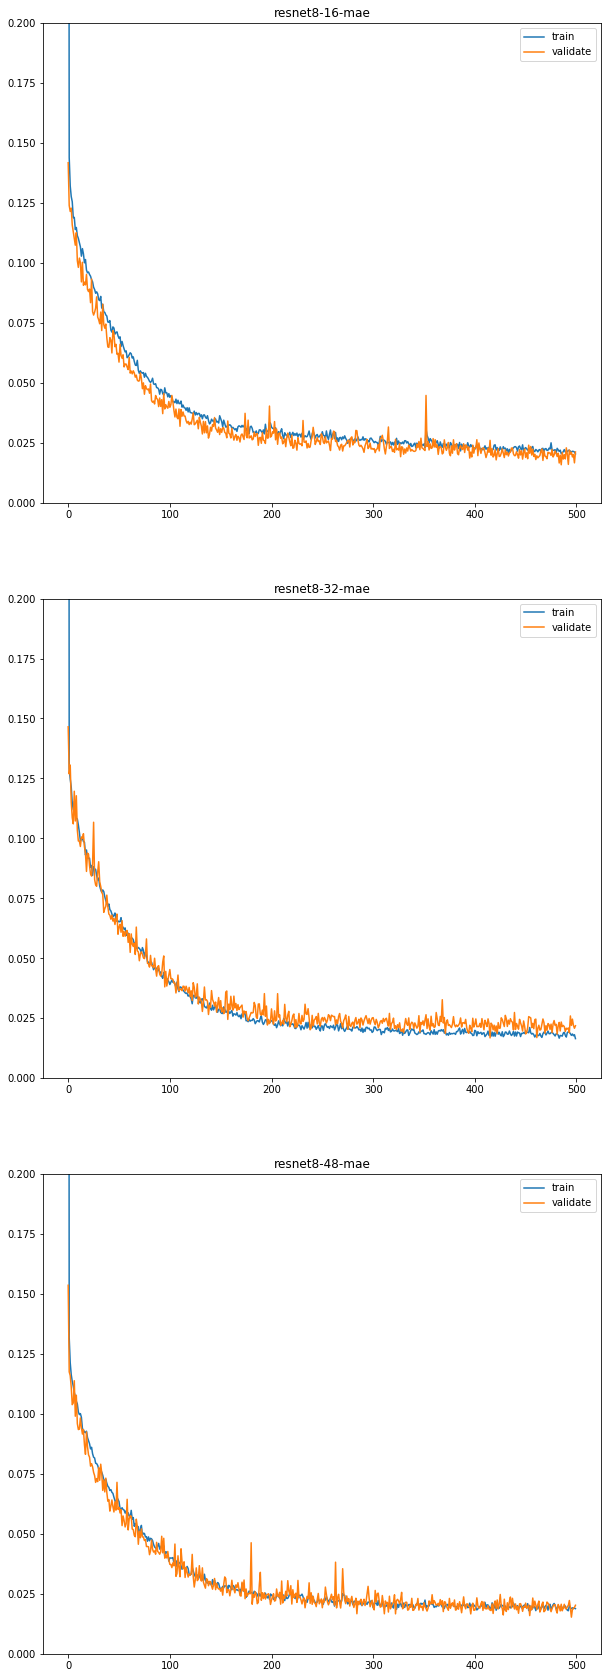

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,1, figsize=(10, 30))

index = 0
for key in sorted(historys.keys()):
    axes[index].plot(historys[key].history['loss'], label='train')
    axes[index].plot(historys[key].history['val_loss'], label='validate')
    axes[index].set_title(key)
    axes[index].legend()
    axes[index].set_ylim(0, 0.2)
    index +=1
    
plt.show()

In [7]:
errors

{'resnet8-16-train': 0.017079434217885138,
 'resnet8-16-val': 0.016340231616050006,
 'resnet8-32-train': 0.01484352839179337,
 'resnet8-32-val': 0.019369325879961253,
 'resnet8-48-train': 0.014933129190467298,
 'resnet8-48-val': 0.015442268829792738}